# Prerequisites

The Human BioMolecular Atlas Program (HuBMAP) aims at the development
of a framework for mapping the human body at a level
of glomeruli functional tissue units.

The [competition](https://www.kaggle.com/c/hubmap-kidney-segmentation/overview)
which inspires this work focuses on the mapping of the human kidney.
The challenge is to detect functional tissue units (FTUs), blocks of cells
centered around a capillary.

## Data Exploration

The competition page provides only few very large `TIFF` files
and a `CSV` with the annotations denoting segmentations of glomeruli.

These extremely large images are not suitable to be processed by segmentation
models and scaling them by a large factor will obviously result in a consistent
loss of details which are needed for the detection.

Our solution consists in splitting the original `TIFF` image in multiple adjacent
pieces which will be processed by the segmentation algorithm independently.

We will illustrate the results of this approach using the lowest resolution
image in the provided dataset.

In [ ]:
import pandas as pd

df = pd.read_csv('train.csv', header=0, index_col=0)
df.head()

,encoding
id,
2f6ecfcdf,296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc,30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4,78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb,101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c,7464094 14 7480273 41 7496453 67 7512632 82 75...


Having inspected the train dataset annotations, we can now focus
only on the second image.

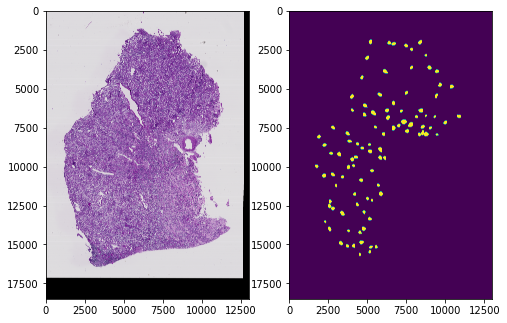

In [ ]:
import matplotlib.pyplot as plt
import tifffile as tiff
from utils import rle_decode

file_name = df.index[1]
encoding = df.iloc[1]['encoding']
img = tiff.imread(file_name + '.tiff')
mask = rle_decode(encoding, (img.shape[1], img.shape[0]))

plt.figure(figsize=(8,15))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(mask);

Inside the `preprocess` folder we have the utilities needed to
split the original image in subsequent patches. The size of the patches
is set to **256**, but you can use any other dimension.

In [ ]:
from preprocess import create_context_target_dataset

create_context_target_dataset(
    files=[file_name],
    encodings=[encoding],
    size=256,
    images_zip='images.zip',
    masks_zip='masks.zip'
);

In [ ]:
%%capture
!unzip images.zip -d images
!unzip masks.zip -d masks
!rm images.zip masks.zip

images_path = 'images'
masks_path = 'masks'

### Statistics

Now that our patches have been created we might be interested in
inspecting them and obtain some interesting statistics about our data.

Total number of training images is 137.
Total number of glomeruli is 130.
Average number of glomeruli per image is 0.948905109489051.
Glomeruli spatial information:


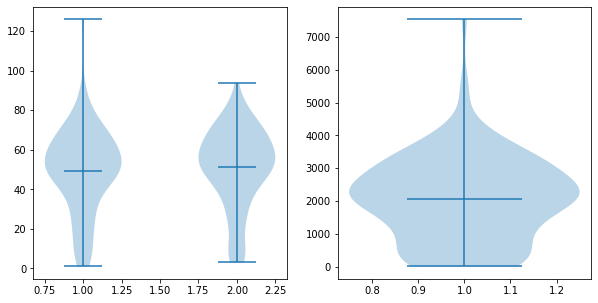

Glomeruli represents the 0.03004734011462135% of the total number of pixels.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

num_glomeruli_per_image = []

glomeruli_filenames = []
glomeruli_widths = []
glomeruli_heights = []
glomeruli_areas = []

filenames = os.listdir(masks_path)

for file in filenames:
    mask = cv2.imread(os.path.join(masks_path, file), 0)
    # output is (num_labels, labelled image, stats, centroids)
    # stats is [[leftmost x coord, topmost y coord, width, height, area] for each label]
    output = cv2.connectedComponentsWithStats(mask, 4, cv2.CV_32S)
    # Update number of glomeruli found
    num_glomeruli_per_image.append(output[0] - 1)
    for stat in output[2]:
        # Exclude background connected component
        if stat[2] == stat[3] == 256:
            continue
        glomeruli_filenames.append(file)
        glomeruli_widths.append(stat[2])
        glomeruli_heights.append(stat[3])
        glomeruli_areas.append(stat[4])

print(f'Total number of training images is {len(filenames)}.')
print(f'Total number of glomeruli is {len(glomeruli_heights)}.')
print(f'Average number of glomeruli per image is {np.mean(num_glomeruli_per_image)}.')

print('Glomeruli spatial information:')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].violinplot(dataset=[glomeruli_widths,
                            glomeruli_heights],
                   showmeans=True)
axes[1].violinplot(dataset=[glomeruli_areas],
                   showmeans=True)

plt.show()

print(f'Glomeruli represents the {np.sum(glomeruli_areas)/(len(filenames)*256*256)}% of the total number of pixels.')

Exploiting the statistics computed above, we can have a look at some interesting images, for instance:
- the one with the largest number of glomerulis
- the one containing the smallest area
- the one containing the largest area

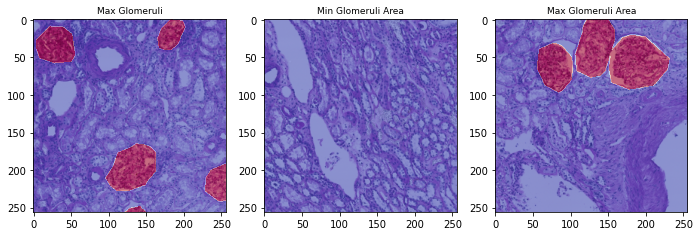

In [ ]:
from PIL import Image
from visualization.visualize_data import display_images_and_masks

images_names = [
    filenames[np.argmax(num_glomeruli_per_image)],
    glomeruli_filenames[np.argmin(glomeruli_areas)],
    glomeruli_filenames[np.argmax(glomeruli_areas)]
]

display_images_and_masks(
    images=[Image.open(os.path.join(images_path, name))
            for name in images_names],
    masks=[Image.open(os.path.join(masks_path, name))
            for name in images_names],
    labels=[
        'Max Glomeruli',
        'Min Glomeruli Area',
        'Max Glomeruli Area'
    ]
)

It is possible to observe that when images are splitted roughly in multiple patches, the possibility of having glomeruli cropped between two or more images is high and may possibly increase the complexity of the problem. 

Other considerations includes the patch size and the image resolution. This arguments will be crucial in the last part of the report, but in general we decided to downsample the original images by 4 and extract patches of 256x256 as illustrated above. Larger patches may lead to more contextual information, while lower downsampling to more details. We believe that this kind of choices depend also on the adopted model, but for simplicity we mainly worked with the mentioned combination trying sometimes other sizes such as 512 and 1024 never observing remarkable benefits.

## Methodology

Now that we have a better understanding of our data, we can focus
on the problem and on the methodology to use for solving it.

### Losses

One of the essential ingredients for any Machine Learning model is obviously the loss
to use during training for backpropagation. 

The literature proposes different functions, we have mainly worked with the following three:

* **Weighted Binary Focal Loss**: A generalized version of the binary cross-entropy loss, where you can penalize hard to classify samples more than easy to classify ones and apply weights to balance the classes. It is computed as $\alpha(1 - p_t)^{\gamma} * log(p_t)$ where $p_t$ is the probability of the foreground class if the class is the foreground, its complement in the other case.
* **Binary Dice Loss**: A measure of the overlapping between the ground truth and the predicted area, measured as $\cfrac{2|X \cap Y|}{|X| + |Y|}$.

* **Combination Loss**: A linear combination of the losses described above.

You can use any of them importing the dedicated layers from `training.loss_functions`.

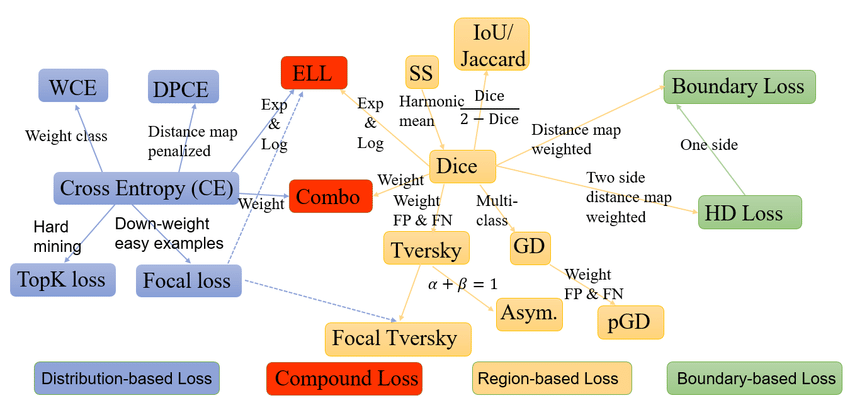

From Ma, Jun. (2020). Segmentation Loss Odyssey.

In [ ]:
from training.loss_functions import BinaryDiceLoss, BinaryFocalLoss, CombinationLoss

### Metrics

While an algorithm is learning and, more importantly, when the training
process is finished, we would like to evaluate how good it is at finding
glomeruli inside a tissue image. For this purpose, we have selected few
metrics to use as reference also for comparing different models each other.

* **IoU**: The amount of pixels at the **intersection** between the predicted mask and the ground truth **over** the **union** of pixels belonging either to the prediction or to the ground truth.
* **Dice Coefficient**: The amount of pixels at the intersection between the predicted mask and the ground truth (x2) over the sum of the areas of the predicted and the ground truth masks. 
* **Pixel Accuracy**: The amount of pixels correctly classified in the mask; this measure is less relevant than the others due to the high number of background pixels which overwhelms incorrect glomeruli segmentation. 

You can use any of them importing the dedicated layers from `evaluation.metrics`.

In [ ]:
from evaluation.metrics import iou, dice_coefficient, pixel_accuracy

### Data Augmentation

Usually, in order to make a model more robust, it might be useful to augment
your dataset applying some transformations to the previously computed patches.

In this particular case, we would like to avoid false detections due to
frequent orientations or particular colors of the glomeruli in the dataset.
An often used approach in this domain is to use transformations:

* **Dihedral Transformations**: The group of symmetries of a regular polygon; in our case of a square they are 8, 4 rotations (0°, 90°, 180°, 270°) and 4 flippings (along the two diagonals and the horizontal and vertical axes).
* **Distortion Transformations**: A non rigid transformation which stretches the image according to a particular rule.
* **Color Transformations**: Alter contrast, saturation and/or color of an image preserving its spatial structure; these are the only ones applied solely on the image and not to both image and mask.

We mostly relied on the `albumentation` library for this purpose.  

In order to give an idea of how much different an image can look like after applying such kind of transformations, we provide some examples below

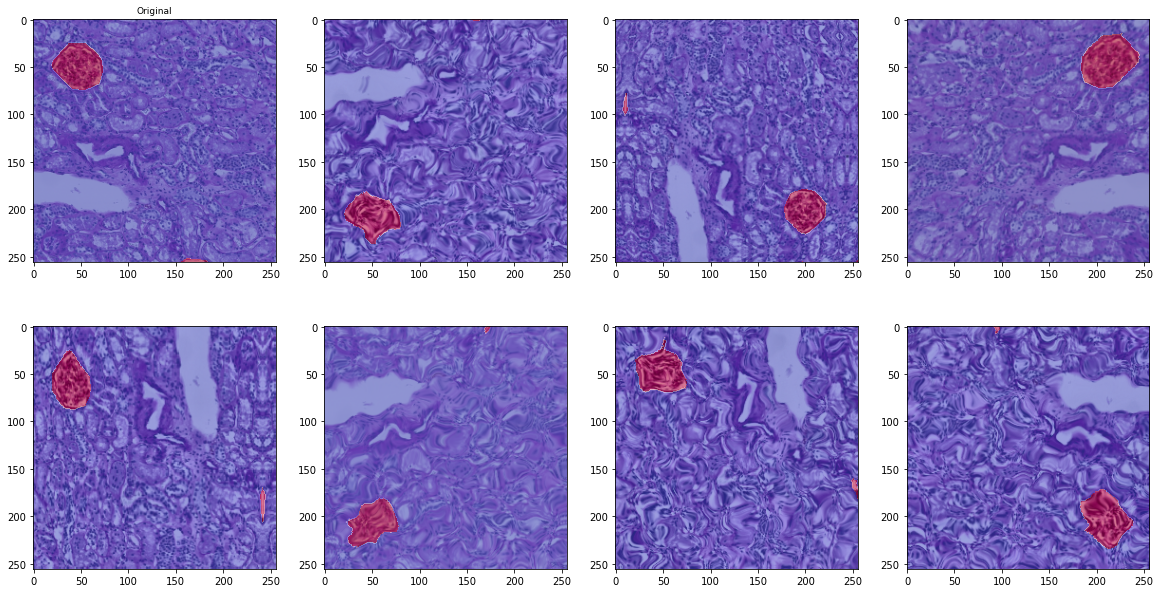

In [ ]:
from preprocess.augmentation import get_augmentations

original_img = Image.open(os.path.join(images_path, 'aaa6a05cc_134.png'))
original_mask = Image.open(os.path.join(masks_path, 'aaa6a05cc_134.png'))

nrows = 2
ncols = 4

augmented_images=[]
augmented_masks=[]
for i in range(0, nrows):
    for j in range(0, ncols):
        prob = 0.0 if i==0 and j==0 else 1.0
        transform = get_augmentations(dihedral_p=prob,
                                      distortion_p=prob,
                                      color_p=prob)

        transformed = transform(image=np.array(original_img), mask=np.array(original_mask))
        augmented_images.append(transformed['image'])
        augmented_masks.append(transformed['mask'])

display_images_and_masks(
    images=augmented_images,
    masks=augmented_masks,
    labels=['Original'] + [None] * (len(augmented_images)-1),
    columns=ncols
)

## Conclusions

In the following parts we will use a precomputed data folder where the same
technique applied here for one image is applied to all the training and validation
images at our disposal.
Augmentation techniques are optionally applied during the dataset creation process.
